<h2>Using SAS DLPy to Create A Tiny YOLOv2 Object Detection Model</h2>


This example uses SAS DLPy to create and train a simple Tiny YOLOv2 object detection model. This object detection model detects and labels objects from two classes in input images. The learning objective is to understand how to use SAS CAS and SAS DLPy to subset and visualize pre-trained model data, define and create a Tiny YOLOv2 object detecton model architecture, attach pre-trained weights for transfer learning, then train the model to perform object detection. 

After training, use the Tiny YOLOv2 object detection model to make predictions and score test data. 

### Table of Contents 
- [Important Note: Client and Server Definitions](#ClientServer)
- [Prepare Resources and Configure Environment for Modeling](#getReady)
    - [Download the Object Detection Example Model Data](#downloadData) 
    - [Download the Pre-trained Model Weights](#downloadWeights)
    - [Import Required Python and SAS DLPy Modules](#importPythonDLPy)
- [Connect to SAS CAS](#connectCAS)
- [Generate the Object Detection Model Source Data](#genSingle)
- [Partition into Train and Test Tables](#partition)
- [Create an ImageTable from the Training Table](#createImageTbl)
    - [Inspect the ImageTable Structure and Contents](#inspectImageTbl)
    - [Examine Object Classes in the Training Data](#ExamineClasses)
- [Get Anchor Boxes from the Training Data](#bestAnchors)    
- [Define the Object Detection Model Architecture](#defineYolov2Model)
- [Load Pretrained Model Weights](#loadWeights)
- [Train the Tiny YOLOv2 Model with Weights](#trainTinyYOLO)
- [Score the Test Data and Display Object Predictions](#scoreTest)
- [Score A Larger Data Set and Display Object Predictions](#scoreLarger)

<a id="ClientServer"></a>

### Important Note: Client and Server Definitions
SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

This step establishes the server-side paths for the model input image data and the model weights. The images are 416 x 416 in size.

In [1]:
# This code defines variables that contain server-side 
# path specifications to the model, image, and weight files 
# for an object detection model. 

# Server path to input images in .sashdat file
model_images = r'/your-system/path-to/object-detection-files'

# Server path to model weights
model_weights = r'/your-system/path-to/object-detection-files'

<a id="getReady"></a>

### Prepare Resources and Configure Environment for Modeling

This section organizes all of the resources that you will need and configures your computing environment for the notebook example. Performing these tasks in advance means you can run the example without multiple stops to locate and download necessary resources. This approach enables you to focus on how to use SAS DLPy to complete the analytic modeling task in this notebook.

<a id="downloadData"></a>

#### Download the Object Detection Example Model Data

This example notebook uses a SAS-generated data set to generate the required train and score data sets. The input data is a collection of 4,554 images in .jpg format. Each input data record contains bounding box, label, and class category information for up to 3 detected objects. 

Download the archived SAS model data [Obj_Det_Soccer_Images_416.zip](https://support.sas.com/documentation/prod-p/vdmml/zip/Obj_Det_Soccer_Images_416.zip) from the [SAS Viya Deep Learning Models and Tools](https://support.sas.com/documentation/prod-p/vdmml/zip/index.html) support page. 

From the archive, extract the input data file `Soccer_Images_416.sashdat` and save it to the server location that you specified previously for the variable `model_images`.

<a id="downloadWeights"></a>

#### Download the Pre-trained Model Weights   

SAS DLPy enables you to use pre-trained model weights with deep learning models that you import or create. The Tiny YOLOv2 model in this example uses the trained weights file `Darknet_Reference_Weights.sashdat` to perform transfer learning and to warm-start model optimization. 

Download the archived model weights file [Obj_Det_Soccer_Weights](https://support.sas.com/documentation/prod-p/vdmml/zip/Obj_Det_Soccer_Weights.zip) from the SAS Viya [Deep Learning Models and Tools page](https://support.sas.com/documentation/prod-p/vdmml/zip/index.html).

Expand the archive and save the weights file `Darknet_Reference_Weights.sashdat` in the server location that you specified earlier for `model_weights`. 

**Note:** If you prefer, the path variables `model_weights` and `model_images` can point to the same folder.

<a id="importPythonDLPy"></a>

#### Import Required Python and SAS DLPy Modules

After copying the input data and pre-trained weights to your server, configure your client computing environment for the analytic task. 

Import the various Python utilities and SAS DLPy modules that this notebook uses. 

The SAS Scripting Wrapper for Analytic Transfer (SWAT) is the Python interface to SAS CAS. You can find more detailed information about starting a SAS CAS session with the SWAT package [here](https://sassoftware.github.io/python-swat/getting-started.html). 

In [2]:
# Import SAS SWAT and SWAT libraries
import swat as sw
from swat import *

# Import prettyprint plot utilities
from pprint import pprint

# Import matplotlib 
import matplotlib
# Display matplotlib output in notebook cells
%matplotlib inline

# Import sys module for OS interaction
import sys

# Import SAS DLPy model building libraries
import dlpy
from dlpy.network import *
from dlpy.layers import *
from dlpy.model import *
from dlpy.images import *
from dlpy.sequential import Sequential
# partition train and test tables in DLPy
from dlpy.splitting import two_way_split
# from dlpy.utils import display_object_detections, plot_anchors
from dlpy.utils import *
from dlpy.applications import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id="connectCAS"></a>
    
### Connect to SAS CAS
After configuring your environment and loading the required libraries and functions, connect to your SAS CAS server and specify your CAS portID. SAS notebook examples use port 5570 by default, but you can substitute another port number of your own choosing.

In [3]:
# Connect to the SAS CAS Server

s = CAS('your-server.your-company.com', 5570)

In [4]:
# Create task caslib named soccer 
s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'},
                  name='soccer',
                  path=model_images,
                  subdirectories=False)

NOTE: Cloud Analytic Services added the caslib 'soccer'.


The `model_images` path variable referenced in the `Path` column points to the server-side folder containing the image data. 
The output shows the caslib `soccer` is created. 

<a id="genSingle"></a>

### Generate the Object Detection Model Source Data 

This step accesses a trained object detection data set saved as a `.sashdat` file. The file `Soccer_Images_416.sashdat` contains 4,554 images with annotations. The images can contain as many as three annotated objects. 

To generate a toy data set for this example, filter the `.sashdat` data to select only images that contain a single annotated object, classified as either `ball` or player `PLA`, and save the resulting CAS table as `single_object`. 

The toy data set `single_object` in this example is arbitrarily created for ease of display and convenience. Object detection models can detect multiple objects per image; there is no analytic requirement for object detection models to use single-object image data.

The `single_object` table is partitioned to create the `trainset` and `testset` tables used in this example.


In [5]:
# Generate the toy data table

whereStr = "_nObjects_=1"

# load the filtered observations and create SAS CAS 
# table 'single_object' in caslib soccer

# Save CAS table 'single_object' as a Python object 'single_object'
# to enable the use of Python commands with the CAS table.
single_object = s.table.loadtable(casout={'name':'single_object', 
                                          'replace':True, 
                                          'blocksize':350},
                                  caslib='soccer',   
                                                
# The SAS soccer data set with detected objects and labels (226MB)                            
                                  path='Soccer_Images_416.sashdat',   

# End the where-clause filter
                                  where=whereStr).casTable                               
                              

NOTE: Cloud Analytic Services made the file Soccer_Images_416.sashdat available as table SINGLE_OBJECT in caslib CASUSER(userID).


Use the CAS `tableinfo()` function to verify that the source data table of single-object images was created:

In [6]:
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,SINGLE_OBJECT,1081,25,0,utf-8,2020-11-16T16:46:27-05:00,2020-11-16T16:46:27-05:00,2020-11-16T16:46:27-05:00,UTF8,1.921182e+09,...,0,0,0,Soccer_Images_416.sashdat,soccer,0,userID,,2020-06-02T10:53:06-05:00,1.906732e+09


The table `single_object` contains 1,081 images that can be used for object detection modeling. 

Use the CAS `columnInfo()` function to examine the columns in the table:

In [7]:
s.table.columnInfo(single_object)

,Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,imgNo,,1,char,18,18,,0,0
1,_image_,,2,varbinary(image),61078,61078,,0,0
2,_size_,,3,int64,8,19,F,19,0
3,_path_,,4,varchar,45,45,,0,0
4,_type_,,5,char,3,3,,0,0
5,_id_,,6,int64,8,19,F,19,0
6,_label_,,7,varchar,0,1,,0,0
7,var0,,8,varchar,1,1,,0,0
8,im_path,,9,varchar,15,15,,0,0
9,_nObjects_,,10,double,8,12,,0,0


The table `single_object` contains 1,081 rows and 25 columns. Note that column metadata is included for up to 3 objects per image, in the columns that begin with `_Object0_`, `_Object1_`, and `_Object2_`. The toy data set `single_object` contains only single object images, so the ten columns that contain metadata for images with a second or third object (columns that begin with `_Object1_` and `_Object2_`) are removed when creating the `trainset` and `testset` tables. 

<a id="partition"></a>
   
### Partition into Train and Test Tables

Use the `single_object` table with the DLPy _two_way_split()_ function to create a train data table `trainset` with 80% of the observations, and a test data table `testset` with the remaining 20% of the observations. The `random_seed` value ensures repeatability in partitioning results if you are following along in a session of your own.

In [8]:
# Partition table 'single_object'  
# using two_way_split()
# 80% train, 20% test tables 

# Python name 'source_data' for CAS 
# table 'single_object'
source_data = s.CASTable('single_object')

# list of columns to retain in two_way_split()
# Omits unneeded columns in the new tables
column_list = ['imgNo', '_size_', 
               '_path_', '_type_', 
               'var0', 'im_path', 
               '_nObjects_', '_Object0_', 
               '_Object0_x', '_Object0_y', 
               '_Object0_width', 
               '_Object0_height']

# Partition 80% 'trainset', 20% 'testset'
# using the shuffled data in 'single_object'
trainset, testset = two_way_split(source_data, 
                                  # random sample without stratification
                                  stratify=False,
                                  # 20% test partition                                  
                                  test_rate=20, 
                                  # output CAS table name for train set
                                  train_name='trainset',
                                  # output CAS table name for test set
                                  test_name='testset',
                                  # list of columns to keep
                                  columns=column_list,
                                  # random seed 
                                  seed=411,
                                  )

# Display all of the tables in caslib 'soccer' including 
# the new train and test tables
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,SINGLE_OBJECT,1081,25,0,utf-8,2020-11-16T16:46:27-05:00,2020-11-16T16:46:27-05:00,2020-11-16T16:46:37-05:00,UTF8,1.921182e+09,...,0,0,0,Soccer_Images_416.sashdat,soccer,0,userID,,2020-06-02T10:53:06-05:00,1.906732e+09
1,TRAINSET,865,16,0,utf-8,2020-11-16T16:46:37-05:00,2020-11-16T16:46:37-05:00,2020-11-16T16:46:37-05:00,UTF8,1.921182e+09,...,0,0,0,,,0,userID,,,NaN
2,TESTSET,216,16,0,utf-8,2020-11-16T16:46:38-05:00,2020-11-16T16:46:38-05:00,2020-11-16T16:46:38-05:00,UTF8,1.921182e+09,...,0,0,0,,,0,userID,,,NaN


The new tables `trainset` (with 865 observations) and `testset` (with 216 observations) are the newly-partitioned 80%  train and 20% test tables. As expected, the number of columns in table  `single_object` is reduced from 25 to 16 in the tables `trainset` and `testset`. From table `single_object`'s 25 columns, 10 columns that contain parameters for second and third objects are removed. One column `_filename_0` that contains image filenames is added, resulting in `trainset` and `testset` tables with 16 columns. 

In [9]:
# Save CAS tables 'trainset' and 'testset' 
# as named Python objects that point to the CAS 
# tables, in order to use of Python commands 
# with the CAS tables.

train_set = s.CASTable(name="trainset")
test_set = s.CASTable(name="testset")

<a id="createImageTbl"></a>

### Create an ImageTable from the Training Table

Before going further, create an imageTable from the table `trainSet`.

ImageTables by definition do not include annotation data. The imageTable created below has only 4 columns, as opposed to 16 columns in the `trainset` table that it was created from. Use the imageTable to visually examine the single-object images extracted from the source data to ensure clarity, consistency, and correct content. 

In [10]:
# Create ImageTable 'trainSetTbl' using the Python variable 'train_set' 
# for the CAS table 'trainset' 

# Note: The imageTable 'trainSetTbl' is used in order to inspect and verify 
# the raw input data image contents and dimensions. It is not used for training.
trainSetTbl = ImageTable.from_table(train_set)

# Use Python functions _print()_ and _len()_ to display
# the number of images in the imageTable 'trainSetTbl'.
# It should be the same as are in CAS table 'trainSet'.
print(len(trainSetTbl))

# Display image attribute metadata for the input images
# Verify uniform image sizes of 416 x 416 in the data.
# Use variable 'results' to store output for display.
results = trainSetTbl.fetchImages(to=1000)
print(results.Images['Width'].value_counts())
print(results.Images['Height'].value_counts())

865
NOTE: Table IMAGEDATA_QG6D4Q contains compressed images.
416.0    865
Name: Width, dtype: int64
416.0    865
Name: Height, dtype: int64


The output indicates a new imageTable `IMAGEDATA_QG6D4Q` was created, consisting of 865 images uniformly sized 416 pixels by 416 pixels.

<a id="inspectImageTbl"></a>

#### Inspect the ImageTable Structure and Contents

What does imageTable `trainSetTbl` table look like? Use _columninfo()_ to display the table organization. Then use the _head()_ function to display column and row contents:

In [11]:
# Display the column information for 
# the imageTable 'trainSetTbl'
trainSetTbl.columninfo()

,Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,_image_,,1,varbinary(image),59700,59700,,0,0
1,_label_,,2,varchar,0,1,,0,0
2,_filename_0,,3,varchar,15,15,,0,0
3,_id_,,4,int64,8,19,F,19,0


In [12]:
# Display a table of 5 observations from the imageTable  
trainSetTbl.head(5)

,_image_,_label_,_filename_0,_id_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,,_0712429103.jpg,342
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,,_8200574133.jpg,2053
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,,_0156385992.jpg,252
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,,_7132597459.jpg,2322
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,,_7085442722.jpg,264


The `trainSetTbl` imageTable _image_summary_ option makes it easy to verify that all 865 single-object images extracted from the source CAS table `trainset` are uniformly 416 pixels wide by 416 pixels high in size. The ouput also includes mean BGR channel values that can be useful during model training.

In [13]:
# Show a metadata summary for the images in 
# imageTable 'trainSetTbl'
trainSetTbl.image_summary

jpg                   865
minWidth              416
maxWidth              416
minHeight             416
maxHeight             416
meanWidth             416
meanHeight            416
mean1stChannel    133.106
min1stChannel           0
max1stChannel         255
mean2ndChannel      124.1
min2ndChannel           0
max2ndChannel         255
mean3rdChannel      139.9
min3rdChannel           0
max3rdChannel         255
dtype: object

Visually, what do the images in imageTable `trainSetTbl` actually look like?  Are they clear and distinct?

Use the `show()` function to display 6 random images from the table. 

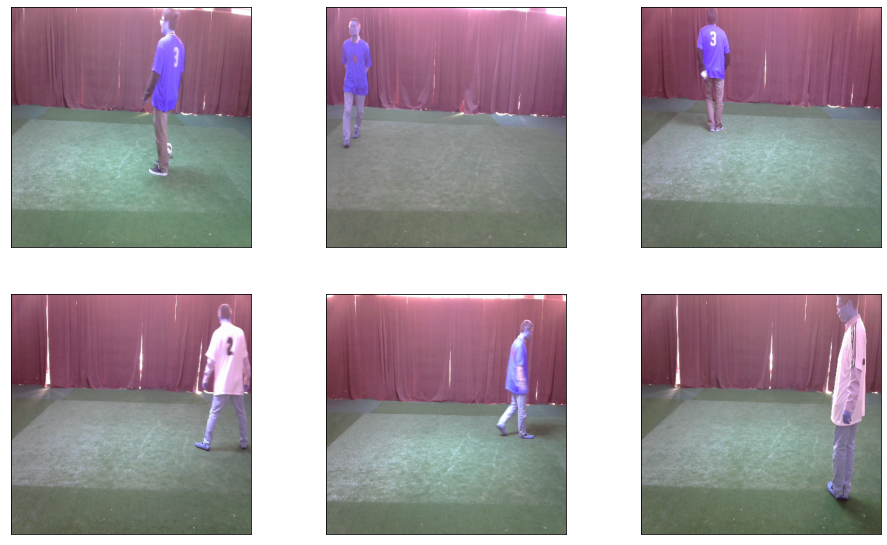

In [14]:
# Display 6 random images from the imageTable 
# 'trainSetTbl' in 4 columns 
trainSetTbl.show(nimages=6, 
                 ncol=3, 
                 randomize=True)

The images from imageTable `trainSetTbl` are uniform in size and contain only single objects (ball or player). The CAS training table `train_set` shares the same images, but with annotation data for detected objects.

<a name="ExamineClasses"></a>

####  Examine Object Classes in the Training Data 

After using an imageTable to verify the subsetted training data image contents, examine the full CAS train table. What is the distribution between `player` and `ball` object image classes in the train and test tables? 

Use `simple.freq()` to generate a frequency table of the `trainset` and `testset` classes across the `vars` labels for `_Object0_`, which is (player `PLA` and `Ball`).

In [15]:
s.simple.freq(table={'name':'trainset','vars':[{'name':'_Object0_'}]})

,Column,CharVar,FmtVar,Level,Frequency
0,_Object0_,Ball,Ball,1,46.0
1,_Object0_,PLA,PLA,2,819.0


The resulting chart shows the `trainset` table contains 865 images with one detected object. Of the 865 images, 819 contain objects classified as player `PLA`, and 46 contain objects classified as `Ball`.

In [16]:
s.simple.freq(table={'name':'testset','vars':[{'name':'_Object0_'}]})

,Column,CharVar,FmtVar,Level,Frequency
0,_Object0_,Ball,Ball,1,14.0
1,_Object0_,PLA,PLA,2,202.0


The resulting chart shows the `testset` table contains 216 images, with 14 image objects classified as `Ball`, and 202 objects classified as player `PLA`.

<a id="bestAnchors"><a/>
    
#### Get Anchor Boxes from the Training Data

Find the most utilized anchor box dimensions in the training data `trainset` and save the resulting anchor box values. Anchor box values are a list of scalar value pairs that represent the normalized box sizes in width and height for objects to be detected. The normalized box sizes are scalar quantities because they are calculated by dividing the box size (pixels) by the grid size (pixels).

In order, items in an anchor box list represent: 

- AnchorBox1_width, 
- AnchorBox1_height,
- AnchorBox2_width, 
- AnchorBox2_height,
- ...
- AnchorBoxN_width, 
- AnchorBoxN_height

With  `n_anchors=5`, there should be five anchor box value pairs.

Use the SAS DLPy _get_anchors()_ function to retrieve an array that specifies the best `n_anchors` value pairs. 

In [17]:
# Get anchor box values from training data set 
get_anchors(s, 
            data='trainset', 
            n_anchors=5, 
            # width and height values
            coord_type='yolo'
           )

(1.5729657061688307,
 4.2826839826840395,
 0.7831705729166665,
 1.8067274305554788,
 3.723177083333333,
 9.219444444443667,
 2.2859797297297293,
 6.304926801802097,
 1.11182528409091,
 2.716808712121137)

The output returns five anchor box value pairs. It is easier to visualize the anchor box shapes by grouping the output into 5 width by height coordinate pairs:

 (1.57, 4.28)<br>
 (0.78, 1.81) <br>
 (3.72, 9.29) <br>
 (2.29, 6.30) <br>
 (1.11, 2.72) <br>
   
The results show a range of normalized scalar anchor box sizes and shapes: as small as (0.7 x 1.8), and as large as (3.7 x 9.3). Now regenerate the same coordinate values again, this time saving them to a variable named `yolo_anchors`. The anchor box value pairs saved to  `yolo_anchors` are used in the upcoming model definition.

_Note:_ The order and values of the coordinate pairs might vary incrementally on your output.

In [18]:
# Save anchor box value pairs as `yolo_anchors`.
yolo_anchors = get_anchors(s, 
                           data='trainset', 
                           n_anchors=5, 
                           coord_type='yolo'
                           )

What do the annotated images look like? To see sample annotated images from the training data, use the `display_object_detections()` function as follows: 

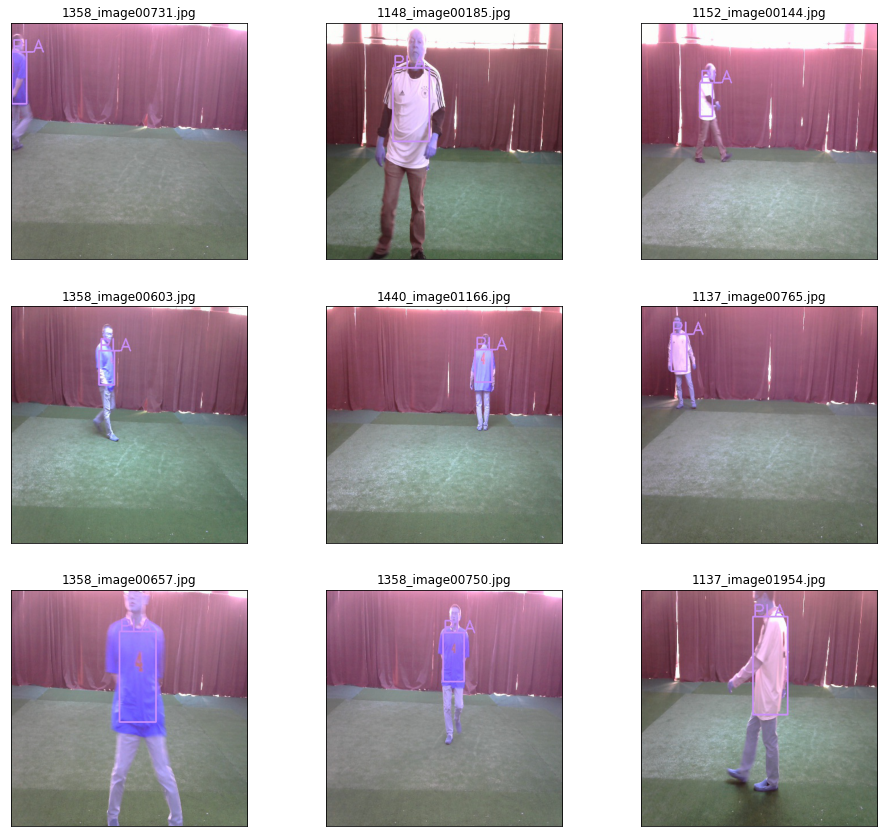

In [19]:
display_object_detections(s, 
                          trainset, 
                          # Use YOLO-type coordinates
                          'yolo', 
                          # 2 classes (player & ball)
                          n_col=3, 
                          # display 9 observations
                          num_plot=9)

<a id="defineYolov2Model"></a>

### Define the Object Detection Model Architecture

Now use SAS DLPy to define the object detection model architecture. This model uses the Tiny YOLOv2 object detection architecture and saves the new model named `yolo_soccer`. The model has 2 output classes (player and ball), and is configured to generate 5 candidates for prediction per grid in the model detection layer. The table `yolo_anchors` contains the anchor shapes. 

The `class_scale` parameter sets the cost function weight for the class of object identified in the detection layer to 1. When objects exist in the grid, `coord_scale` sets the cost function weight in the detection layer to 1. If objects do not exist in the grid, `prediction_not_a_object_scale` sets cost function weight in the detection layer to 1. The `object_scale` sets the cost function weight for objects identified in the detection layer to 5.

The `detection_threshold` for object detections is be set to 0.2. The `iou_threshold` (intersection over union values) for object detection is also set to 0.2.

When you use DLPy to create a `Tiny_YoloV2` model, you do not need to specify individual layers in the architecture. The SAS DLPy API builds a Tiny YOLOv2 model using the parameter values specified in the `Tiny_YoloV2()` function.


In [20]:
# Define TinyYoloV2 Object Detection Model named yolo_soccer
yolo_soccer = Tiny_YoloV2(s, 
                          # player and ball classes 
                          n_classes=2, 
                          # predictions per grid 
                          predictions_per_grid=5, 
                          # previously saved anchor boxes 
                          anchors = yolo_anchors,
                          # max boxes per image
                          max_boxes=5, 
                          # yolo style coordinates 
                          coord_type='yolo',
                          # max labels per image
                          max_label_per_image = 5,
                          class_scale=1.0, 
                          coord_scale=1.0, 
                          prediction_not_a_object_scale=1, 
                          object_scale=5,
                          detection_threshold=0.2, 
                          iou_threshold=0.2)

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Detection layer added.
NOTE: Model compiled successfully.


In [21]:
yolo_soccer.print_summary()


,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,Input1,input,,,None,"(416, 416, 3)","(0, 0)",0
1,1,Convo.1,convo,"(3, 3)","(1, 1)",Identity,"(416, 416, 16)","(432, 0)",74760192
2,2,B.N.1,batchnorm,,,Leaky,"(416, 416, 16)","(0, 32)",0
3,3,Pool1,pool,"(2, 2)","(2, 2)",Max,"(208, 208, 16)","(0, 0)",0
4,4,Convo.2,convo,"(3, 3)","(1, 1)",Identity,"(208, 208, 32)","(4608, 0)",199360512
5,5,B.N.2,batchnorm,,,Leaky,"(208, 208, 32)","(0, 64)",0
6,6,Pool2,pool,"(2, 2)","(2, 2)",Max,"(104, 104, 32)","(0, 0)",0
7,7,Convo.3,convo,"(3, 3)","(1, 1)",Identity,"(104, 104, 64)","(18432, 0)",199360512
8,8,B.N.3,batchnorm,,,Leaky,"(104, 104, 64)","(0, 128)",0
9,9,Pool3,pool,"(2, 2)","(2, 2)",Max,"(52, 52, 64)","(0, 0)",0


<a id="loadWeights"></a>

### Load Pretrained Model Weights

Training an accurate object detection model can be quite challenging. Much time can be saved by importing compatible model weights from an already trained model. Use the trained weights file `Darknet_Reference_Weights.sashdat` at the path specified in `model_weights`. The trained Darknet Reference weights are from a classification model backbone. They are appropriate for this example because the Tiny YOLOv2 model uses the same backbone. 

The following code creates and loads a CAS table `DARKNET_REFERENCE_WEIGHTS` in caslib `soccer`, using the server-side source data in `Darknet_Reference_Weights.sashdat`. 

Using pre-trained model weights gives the example code a warm start on model optimization.

In [22]:
#Load the pre-trained model weights

s. table.loadtable(casout={'name':'DARKNET_REFERENCE_WEIGHTS',
                           'replace':True},
                   caslib='soccer',
                   path="Darknet_Reference_Weights.sashdat"
                  )

NOTE: Cloud Analytic Services made the file Darknet_Reference_Weights.sashdat available as table DARKNET_REFERENCE_WEIGHTS in caslib CASUSER(userID).


[caslib]

 'CASUSER(userID)'

[tableName]

 'DARKNET_REFERENCE_WEIGHTS'

[casTable]

 CASTable('DARKNET_REFERENCE_WEIGHTS', caslib='CASUSER(userID)')

+ Elapsed: 0.00209s, sys: 0.0012s, mem: 0.766mb

You can see in the above results that the CAS table `DARKNET_REFERENCE_WEIGHTS` was created in caslib CASUSER(userID).

In [23]:
# Use 'set_weights()' to load the weights 
# for the object detection model 'soccer'                   
yolo_soccer.set_weights('DARKNET_REFERENCE_WEIGHTS')  

NOTE: Model weights attached successfully!


The following code creates a list named `targets` and a list named `inputVars`. The `targets` variable contains a list of objects along with their bounding box locations. These correspond to the predicted object detections.

The `inputVars` variable is used to specify the image column in a CAS table.


In [24]:
targets = ['_nObjects_'];
for i in range(0,1):
    targets.append('_Object%d_'%i)
    for sp in ["x", "y", "width", "height"]:
        targets.append ('_Object%d_%s'%(i, sp))
                  
inputVars = []
inputVars.insert(0, '_image_')

<a name="trainTinyYOLO"></a>

### Train the Tiny YOLOv2 Model with Weights


After setting `inputVars` and `targets`, train the Tiny YOLOv2 model. Use the pre-trained `Darknet_Reference_Weights` model weights and the subsetted training data that were saved as CAS tables earlier in the example. 

Set `solver` to use a momentum solver with a learning rate of 0.001, using gradient values no smaller than -100 and no larger than 100.  Use `Optimizer()` to specify model optimization settings: solver algorithm, mini-batch size of 64, no more than 10 epochs, and perform L2 regularization using a weight of 0.005. Setting `log_level` to 2 includes epoch history in the output.

Use `DataSpec()` to associate variables with the layers. `inputVars` is for the the model input layer, and `targets` is for the model detection layer, which is the final layer. DataSpec settings are saved in the variable `data_specs`.

Use `Gpu()` to enable GPU processing for GPU0. GPU settings are saved in variable `gpu`. 

Assign the pretrained CAS table of model weights `DARKNET_REFERENCE_WEIGHTS` to the model. 

Use `fit()` to train the model. Use the subsetted data created in CAS table `trainset` for training data. The optimizer settings are saved in `optimizer`, the data_specs settings are saved in `data_specs`, and the model should be single-threaded. Set the `record_seed` value (for random record selection within a worker) to 13309. Force equal padding in convolutional and pooling layers, and use the GPU settings saved in `gpu`. 

In [25]:
solver = MomentumSolver(learning_rate=0.001, 
                        clip_grad_max = 100, 
                        clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=64, 
                      log_level=2, 
                      max_epochs=10, 
                      reg_l2=0.005)
data_specs = [DataSpec(type_='IMAGE', 
                       layer='Input1', 
                       data=inputVars),
              DataSpec(type_='OBJECTDETECTION', 
                       layer='Detection1', 
                       data=targets)]
gpu = Gpu(devices=[0])
yolo_soccer.set_weights('DARKNET_REFERENCE_WEIGHTS')
yolo_soccer.fit(data='trainset', 
               optimizer=optimizer, 
               data_specs=data_specs, 
               n_threads=1, 
               record_seed=13309,
               force_equal_padding=True, 
               gpu=gpu)

NOTE: Model weights attached successfully!
NOTE: Training based on existing weights.
NOTE: Using your-server.unx.company.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 11031952.
NOTE:  The approximate memory cost is 300.00 MB.
NOTE:  Loading weights cost       0.33 (s).
NOTE:  Initializing each layer cost       3.51 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 64.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 64.
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Ball                    
NOTE:  Level      1: PLA                     
NOTE:  Epoch Learning Rate        Loss        IOU   Time(s)
NOTE:  0         0.001           25.35     0.5091     7.86
NOTE:  1         0.001           4.339     0.5464     3.42
NOTE:  2         0.001           3.

,Descr,Value
0,Model Name,tiny-yolov2
1,Model Type,Convolutional Neural Network
2,Number of Layers,25
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,9
6,Number of Pooling Layers,6
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,8
9,Number of Detection Layers,1


The output shows that the Tiny YOLOv2 model was trained using pre-defined weights. The resulting model has 25 layers: 1 input layer, 9 convolutional layers, 6 pooling layers, and 8 batch normalization layers. The model has over 11 million parameters, and after 10 epochs, had a loss of 1.43 and a fit error of 0.337. 

<a id="scoreTest"></a>

### Score the Test Data and Display Object Predictions

Now use `predict()` to score the images in the test data `testset`. Enable use of GPU0 during processing.

In [26]:
#yolo_model.predict(data=predict_tbl, gpu = Gpu(devices=[0]))
yolo_soccer.predict(data='testset', 
                    gpu = Gpu(devices=[0])
                   )

NOTE: Due to data distribution, miniBatchSize has been limited to 4.
NOTE: Using your-server.unx.company.com: 1 out of 2 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           216
 1  Number of Observations Used           216
 2     Average IoU in Detection      0.624455
 3                   Loss Error      2.366743

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(userID)  Valid_Res_CKkwVN   216     5081   
 
                                             casTable  
 0  CASTable('Valid_Res_CKkwVN', caslib='CASUSER(c...  

+ Elapsed: 4.2s, user: 3.82s, sys: 2.39s, mem: 1.79e+03mb

The output above shows an output CAS table `Valid_Res_CKkVN` containing scored image data was created.

Now, use `display_object_detections()` with `valid_res_tbl` to create a 3-column matrix of scored images, showing object detection bounding boxes with label and probability score.  

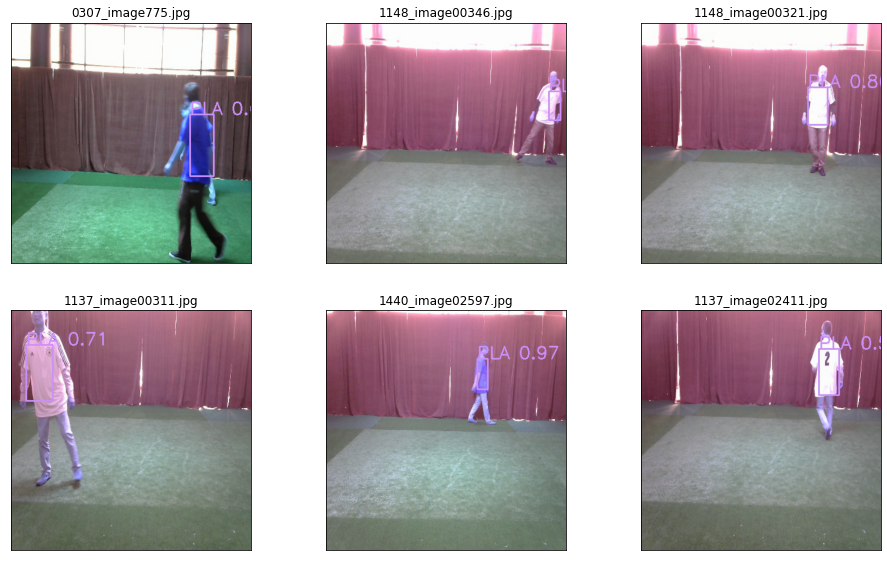

In [27]:
display_object_detections(conn=s, 
                          coord_type='yolo', 
                          max_objects=1, 
                          table=yolo_soccer.valid_res_tbl, 
                          num_plot=6,
                          n_col=3)

<a id="scoreLarger"></a>

### Score A Larger Data Set and Display Object Predictions

Now evaluate the performance of the Tiny YOLOv2 object detection model by using `predict()` to detect and identify objects in the much larger training data set `trainset`. Use one GPU (GPU0) during processing. Set `buffer_size` to 1 in order to score 1 observation per batch:


In [28]:
yolo_soccer.predict(data='trainset', 
                    gpu=Gpu(devices=[0]), 
                    buffer_size=1
                   )

NOTE: Using your-server.unx.company.com: 1 out of 2 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           865
 1  Number of Observations Used           865
 2     Average IoU in Detection      0.661676
 3                   Loss Error      1.328568

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(userID)  Valid_Res_CKkwVN   865     5081   
 
                                             casTable  
 0  CASTable('Valid_Res_CKkwVN', caslib='CASUSER(c...  

+ Elapsed: 4.3s, user: 12s, sys: 5.41s, mem: 1.82e+03mb

The model results show 865 scored observations with an average IOU (Intersection over Union) score of 0.66 and a loss of 1.33.

Now display scored object detections:


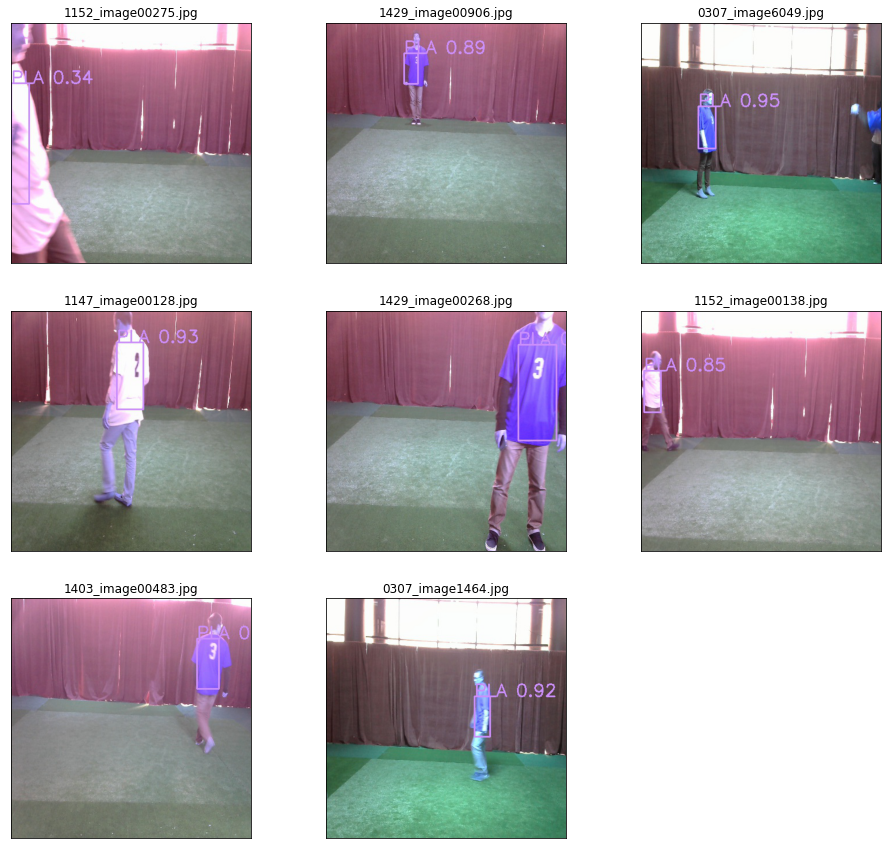

In [29]:
display_object_detections(conn=s, 
                          coord_type='yolo', 
                          max_objects=1, 
                          table=yolo_soccer.valid_res_tbl, 
                          num_plot=8,
                          n_col=3)